***Cancer Detection***

Throughout this interactive computing environment, our objective is to develop a Convolutional Neural Network (CNN) model capable of precisely identifying the presence or absence of cancer based on pathological imaging data. The dataset employed in this endeavor originates from the Kaggle competition titled "Histopathologic Cancer Detection," which can be accessed at the following URL:
https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2024-04-29 20:10:27.838298: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 20:10:28.008899: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 20:10:29.428063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 20:10:33.258815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


***Load Data***

In [2]:
train_df = pd.read_csv('work/train_labels.csv')
train_path = 'work/train/'

***Constants***

In [3]:
IMAGE_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 10

***Exploratory Data Analysis (EDA)***

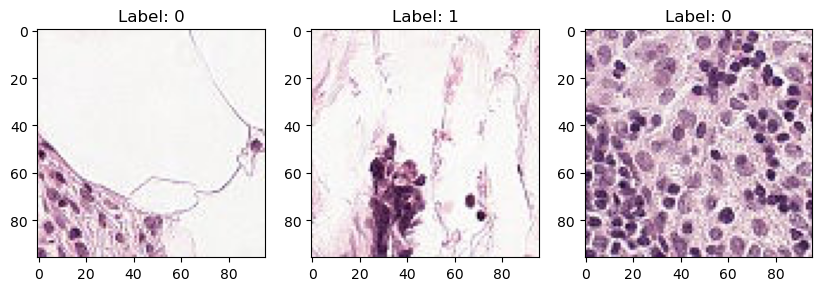

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    img_name = train_df.iloc[i]['id'] + '.tif'
    img = load_img(os.path.join(train_path, img_name), target_size=IMAGE_SIZE)
    axs[i].imshow(img)
    axs[i].set_title('Label: ' + str(train_df.iloc[i]['label']))
plt.show()

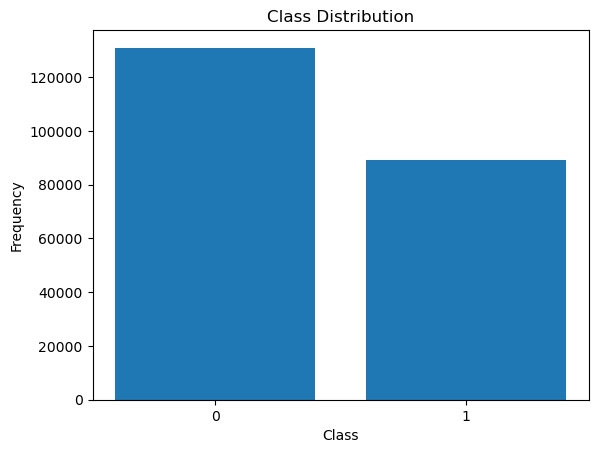

In [5]:
# Display class distribution
class_distribution = train_df['label'].value_counts()
plt.bar(class_distribution.index.astype(str), class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

***Preprocess the images***

In [10]:
def preprocess_images(df):
    df['id'] = df['id'] + '.tif'  # Append '.tif' to match filenames
    return df

train_df = preprocess_images(train_df)

# Convert the 'label' column to strings
train_df['label'] = train_df['label'].astype(str)

***Split the dataset into training and validation sets***

In [11]:
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42)

***Data Augmentation and Image Data Generators***

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(train_set,
                                                    directory=train_path,
                                                    x_col='id',
                                                    y_col='label',
                                                    target_size=IMAGE_SIZE,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE)

Found 176020 validated image filenames belonging to 2 classes.


In [14]:
val_generator = val_datagen.flow_from_dataframe(val_set,
                                                directory=train_path,
                                                x_col='id',
                                                y_col='label',
                                                target_size=IMAGE_SIZE,
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE)

Found 44005 validated image filenames belonging to 2 classes.


***Build the model***

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


***Train the model***

In [16]:
print("Length of train_generator:", len(train_generator))
print("Length of val_generator:", len(val_generator))

Length of train_generator: 5501
Length of val_generator: 1376


In [17]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=min(len(train_generator), EPOCHS),
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps=min(len(val_generator), EPOCHS))

Epoch 1/10


/opt/conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 971ms/step - accuracy: 0.5663 - loss: 1.1347 - val_accuracy: 0.6094 - val_loss: 0.6629
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 462ms/step - accuracy: 0.5657 - loss: 0.6765 - val_accuracy: 0.6250 - val_loss: 0.5852
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.5863 - loss: 0.6364 - val_accuracy: 0.6719 - val_loss: 0.6530
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.6894 - loss: 0.5954 - val_accuracy: 0.7063 - val_loss: 0.6601
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.7283 - loss: 0.5248 - val_accuracy: 0.7063 - val_loss: 0.7140
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - accuracy: 0.7298 - loss: 0.5324 - val_accuracy: 0.7969 - val_loss: 0.4943
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.6718 - loss: 0.5995 - val_accuracy: 0.6656 - val_loss: 0.6252
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.7554 - loss: 0.5379 - val_accuracy: 0.7188 - val

***Evaluate the model***

In [18]:
val_loss, val_acc = model.evaluate(val_generator, steps=len(val_generator))
print("Validation Accuracy:", val_acc)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 135s 98ms/step - accuracy: 0.7338 - loss: 0.5718
Validation Accuracy: 0.7313941717147827


***Visualize training history***

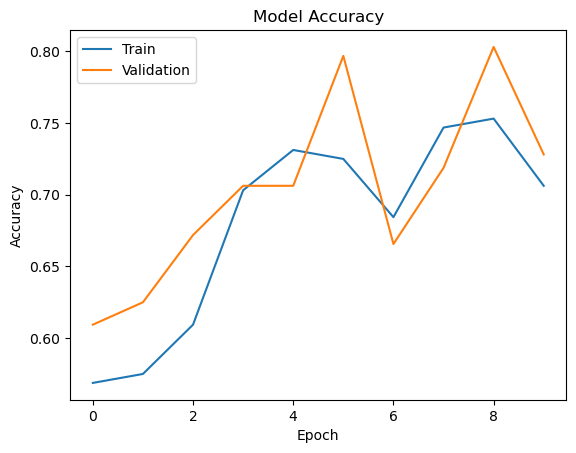

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

***Confusion matrix and classification report***

In [21]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator, steps=len(val_generator))
print("Validation Accuracy:", val_acc)

# Get predictions on validation data
val_pred = model.predict(val_generator)

# Convert predictions and true labels to appropriate format
val_pred_classes = np.round(val_pred).astype(int)
val_true_classes = val_set['label'].astype(int).values

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
class_report = classification_report(val_true_classes, val_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 126s 92ms/step - accuracy: 0.7309 - loss: 0.5770
Validation Accuracy: 0.7313941717147827
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 123s 90ms/step
Confusion Matrix:
[[19290  6887]
 [13043  4785]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.74      0.66     26177
           1       0.41      0.27      0.32     17828

    accuracy                           0.55     44005
   macro avg       0.50      0.50      0.49     44005
weighted avg       0.52      0.55      0.52     44005



***Conclusion:***  The histopathologic cancer detection model achieved an overall accuracy of 55% on the validation dataset, consisting of 44,005 samples. The precision, recall, and F1-score metrics provide further insights into the model's performance for each class.

The model exhibits relatively higher precision and recall for classifying non-cancerous images. However, there is still room for improvement, especially in terms of precision, which indicates the proportion of true non-cancerous images among all predicted non-cancerous images.

The model's performance is weaker for classifying cancerous images, as indicated by lower precision, recall, and F1-score values. This suggests that the model struggles to accurately identify cancerous images, leading to a higher number of false negatives.